EvoGGen vs. Alhazen-py
===

In [1]:
# !pip install alhazen-py

In [2]:
from evogfuzz_formalizations.calculator import grammar as grammar, initial_inputs

In [3]:
import string

grammar = {
    "<start>":
        ["<function>(<term>)"],

    "<function>":
        ["sqrt", "tan", "cos", "sin"],
    
    "<term>": ["-<value>", "<value>"], 
    
    "<value>":
        ["<integer>.<integer>",
         "<integer>"],

    "<integer>":
        ["<digit><integer>", "<digit>"],

    "<digit>":
        ["1", "2", "3", "4", "5", "6", "7", "8", "9"]
}
    

In [4]:
for inp in initial_inputs:
    print(inp)

cos(12)
sqrt(-900)


In [5]:
from evogfuzz.oracle import OracleResult
import math

def arith_eval(inp) -> float:
    return eval(
        str(inp), {"sqrt": math.sqrt, "sin": math.sin, "cos": math.cos, "tan": math.tan}
    )

def oracle(inp: str) -> OracleResult:
    try:
        arith_eval(inp)
        return OracleResult.NO_BUG
    except ValueError:
        return OracleResult.BUG
    
    return OracleResult.NO_BUG

## EvoGGen

In [6]:
from evogfuzz.evogfuzz_class import EvoGGen

egg = EvoGGen(
    grammar=grammar,
    inputs=["sqrt(-1)"],
    oracle=oracle,
    transform_grammar=True,
    iterations=20
)

In [7]:
failure_inducing_grammar, failing_inputs = egg.optimize()

In [8]:
for inp in list(failing_inputs)[:20]:
    print(inp, oracle(inp))

sqrt(-8.85) BUG
sqrt(-8558585.885) BUG
sqrt(-8.5851) BUG
sqrt(-58858.858885) BUG
sqrt(-1.8885) BUG
sqrt(-55.5588) BUG
sqrt(-8551.8855855888) BUG
sqrt(-58.58858) BUG
sqrt(-5858555885585858.555) BUG
sqrt(-55888.88888) BUG
sqrt(-1) BUG
sqrt(-585.8585) BUG
sqrt(-888885858.55885588) BUG
sqrt(-5.8) BUG
sqrt(-5.888) BUG
sqrt(-1) BUG
sqrt(-81.55851) BUG
sqrt(-88.851) BUG
sqrt(-58881.1) BUG
sqrt(-5.58) BUG


In [9]:
failure_inducing_grammar

{'<start>': [('<rules>', {'prob': None})],
 '<function>': [('sqrt', {'prob': 1.0}),
  ('tan', {'prob': 0.0}),
  ('cos', {'prob': 0.0}),
  ('sin', {'prob': 0.0})],
 '<term>': [('-<value>', {'prob': 1.0}),
  ('<value>', {'prob': 0.0}),
  ('-1', {'prob': 0.0})],
 '<value>': [('<integer>.<integer>', {'prob': 1.0}),
  ('<integer>', {'prob': 0.0}),
  ('1', {'prob': 0.0})],
 '<integer>': [('<digit><integer>', {'prob': 0.6565295169946332}),
  ('<digit>', {'prob': 0.22182468694096602}),
  ('1', {'prob': 0.12164579606440072})],
 '<digit>': [('1', {'prob': 0.0}),
  ('2', {'prob': 0.0}),
  ('3', {'prob': 0.0}),
  ('4', {'prob': 0.0}),
  ('5', {'prob': 0.48879837067209775}),
  ('6', {'prob': 0.0}),
  ('7', {'prob': 0.0}),
  ('8', {'prob': 0.5112016293279023}),
  ('9', {'prob': 0.0})],
 '<rules>': [('<function>(<term>)', {'prob': 0.9948186528497409}),
  ('sqrt(-1)', {'prob': 0.0051813471502590676})]}

### Evaluation

In [10]:
# !pip install timer

In [11]:
from fuzzingbook.ProbabilisticGrammarFuzzer import ProbabilisticGrammarFuzzer
from isla.language import DerivationTree
from evogfuzz.input import Input
from timer import timer

evoggen_generator = ProbabilisticGrammarFuzzer(failure_inducing_grammar)

generated_samples = list()
with timer() as t:
    for _ in range(1000):
        inp = evoggen_generator.fuzz_tree()
        generated_samples.append(inp)
print(t.elapse)

0.5334895000560209


In [12]:
from fuzzingbook.Parser import tree_to_string
clean_eval_data = set()
for inp in generated_samples:
    clean_eval_data.add(
        Input(
            tree=DerivationTree.from_parse_tree(
                inp
            ),
            oracle=oracle(tree_to_string(inp))
        )
    )

In [13]:
print(len(clean_eval_data))
print(f"time per inp: {t.elapse/len(clean_eval_data)}")

655
time per inp: 0.0008144877863450701


In [14]:
for inp in list(clean_eval_data)[:10]:
    print(str(inp), inp.oracle)

sqrt(-8.5558581) BUG
sqrt(-1.8585) BUG
sqrt(-85858.588) BUG
sqrt(-558.58) BUG
sqrt(-55555.85) BUG
sqrt(-1.8885) BUG
sqrt(-581.85) BUG
sqrt(-5888.85) BUG
sqrt(-81.555) BUG
sqrt(-888588885855.551) BUG


## Alhazen

In [15]:
# !pip uninstall -y alhazen-py

In [16]:
# !pip install git+https://github.com/martineberlein/alhazen-py.git@dev

In [17]:
from alhazen.oracle import OracleResult

def oracle_alhazen(inp: str) -> OracleResult:
    try:
        arith_eval(inp)
        return OracleResult.NO_BUG
    except ValueError:
        return OracleResult.BUG
    return OracleResult.UNDEF

In [18]:
from alhazen import Alhazen
from alhazen.features import EXISTENCE_FEATURE, NUMERIC_INTERPRETATION_FEATURE

alhazen = Alhazen(
    initial_inputs=["sqrt(-1)", "cos(9)"],
    grammar=grammar,
    evaluation_function=oracle_alhazen,
    features={EXISTENCE_FEATURE, NUMERIC_INTERPRETATION_FEATURE}
)
trees = alhazen.run()

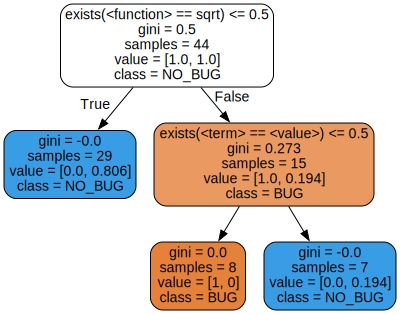

In [19]:
alhazen.show_model()

In [23]:
from alhazen.generator import AdvancedGenerator

generator = AdvancedGenerator(grammar)

tests = [10, 20, 50, 100, 500, 1000]
times = list()
for test in tests:
    test_samples = set()
    with timer() as t:
        for _ in range(test):
            inp = (alhazen.generate(bug_triggering=True, generator=generator))
            # print(inp)
            test_samples.add(inp)
    times.append(t.elapse)

In [24]:
print(times)

[0.5462624579668045, 0.8942337499465793, 2.2087065409868956, 4.414274333044887, 22.10252979095094, 44.95534254203085]


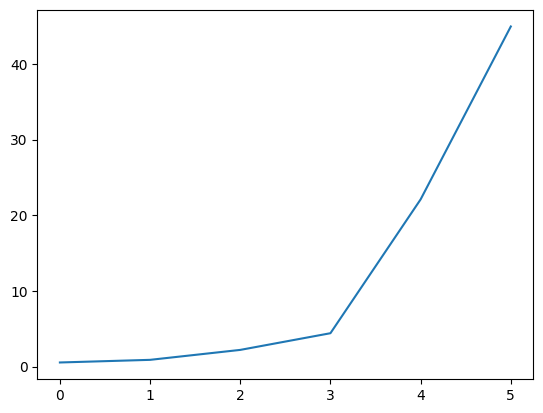

In [26]:
from matplotlib.pyplot import plot

plot(times)

In [21]:
print(t.elapse)
print(len(test_samples))
print(t.elapse/len(test_samples))

44.17613341694232
641
0.06891752483142327


In [22]:
for inp in list(test_samples)[:20]:
    print(inp)

sqrt(-78)
sqrt(-5.56)
sqrt(-64.3)
sqrt(-2.539)
sqrt(-33.8)
sqrt(-34.2)
sqrt(-95)
sqrt(-8.12)
sqrt(-4462.43)
sqrt(-78443)
sqrt(-79)
sqrt(-9336)
sqrt(-56)
sqrt(-35.7)
sqrt(-54637.12)
sqrt(-232459)
sqrt(-9498)
sqrt(-4.495)
sqrt(-5124)
sqrt(-48.3)
